In [3]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score , mean_squared_log_error 
import seaborn as sns



In [4]:
movielens_dir = "../ml-25m/"
ratings_file = movielens_dir + "ratings.csv"
df = pd.read_csv(ratings_file)


In [5]:
df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [5]:
##df = df.sample(n = 1000000)
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])



print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 162541, Number of Movies: 59047, Min rating: 0.5, Max rating: 5.0


In [6]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,296,5.0,1147880044,0,0
1,1,306,3.5,1147868817,0,1
2,1,307,5.0,1147868828,0,2
3,1,665,5.0,1147878820,0,3
4,1,899,3.5,1147868510,0,4
...,...,...,...,...,...,...
25000090,162541,50872,4.5,1240953372,162540,544
25000091,162541,55768,2.5,1240951998,162540,4574
25000092,162541,56176,2.0,1240950697,162540,7115
25000093,162541,58559,4.0,1240953434,162540,578


In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.7 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)
print(len(x_train))
print(len(x_val))



17500066
7500029


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 162541, 590  0           []                               
                                47)]                                                              
                                                                                                  
 tf.__operators__.getitem_8 (Sl  (None, 59047)       0           ['input_3[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_10 (S  (None, 59047)       0           ['input_3[0][0]']                
 licingOpLambda)                                                                            

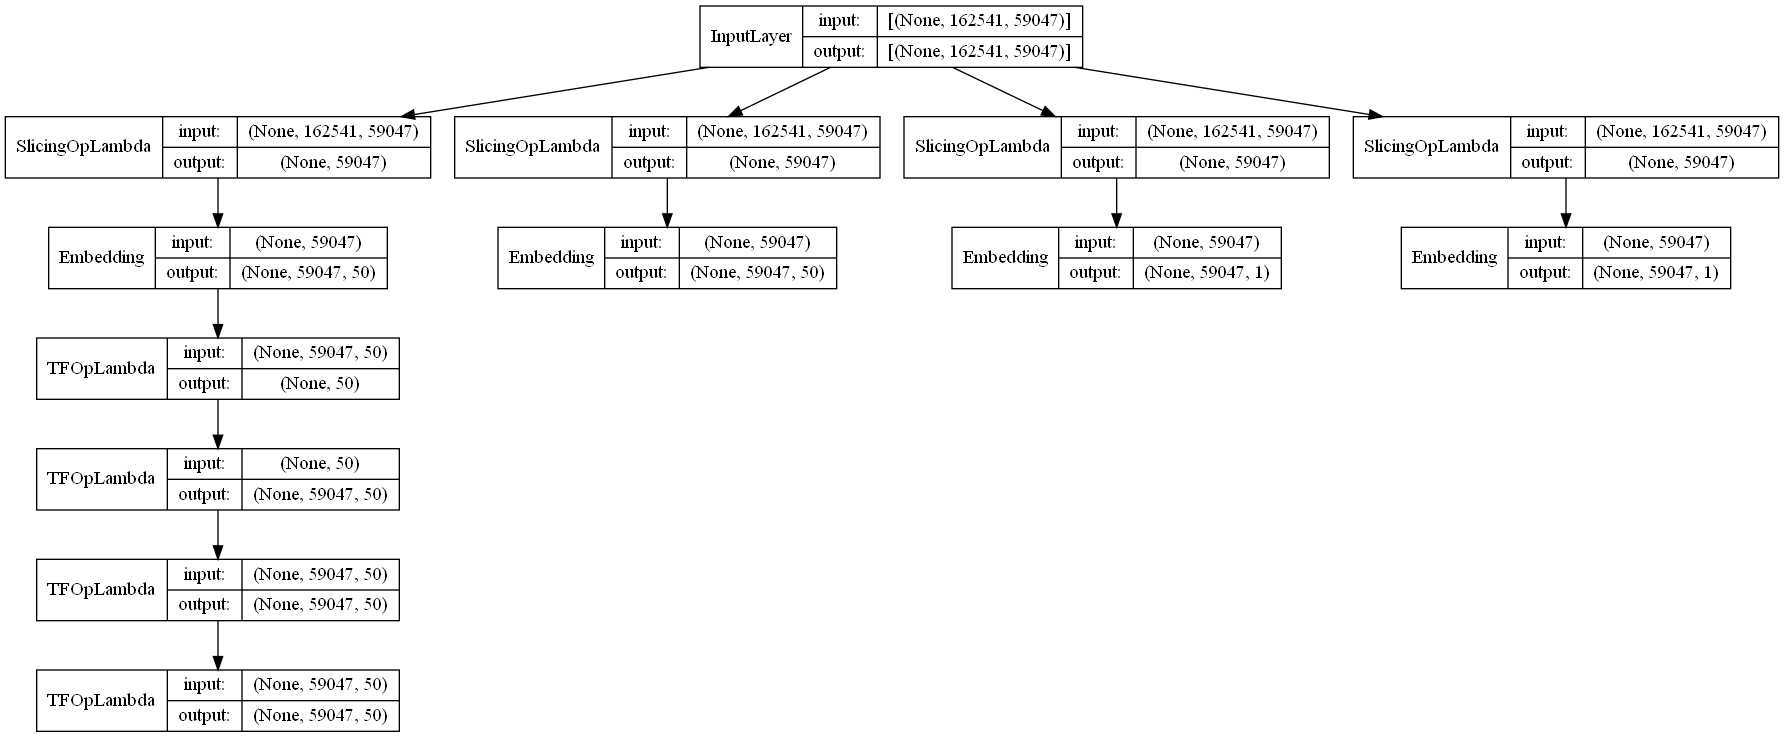

In [12]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)
    
    # función para graficar el modelo 
    def build_graph(self):
        x = layers.Input(shape=(self.num_users,self.num_movies))
        return Model(inputs=[x], outputs=self.call(x))


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.00005)
)

model.build(x_train.shape)
model.build_graph().summary()
plot_model(model.build_graph(), to_file='model_plot.png', show_shapes=True, show_layer_names=False)




# Entrenar el modelo

In [23]:
history = model.fit(
    x=x_train,
    y=y_train, 
    batch_size=1024,
    epochs=10,
    verbose=1,    
    ##steps_per_epoch=5000,
    validation_data=(x_val, y_val)
)

Epoch 1/10
8545/8545 [==============================] - 744s 87ms/step - loss: 0.6324 - val_loss: 0.6199
Epoch 2/10
8545/8545 [==============================] - 755s 88ms/step - loss: 0.6159 - val_loss: 0.6125
Epoch 3/10
8545/8545 [==============================] - 761s 89ms/step - loss: 0.6098 - val_loss: 0.6077
Epoch 4/10
8545/8545 [==============================] - 768s 90ms/step - loss: 0.6059 - val_loss: 0.6045
Epoch 5/10
8545/8545 [==============================] - 765s 90ms/step - loss: 0.6031 - val_loss: 0.6021
Epoch 6/10
8545/8545 [==============================] - 777s 91ms/step - loss: 0.6010 - val_loss: 0.6003
Epoch 7/10
8545/8545 [==============================] - 778s 91ms/step - loss: 0.5992 - val_loss: 0.5988
Epoch 8/10
8545/8545 [==============================] - 769s 90ms/step - loss: 0.5978 - val_loss: 0.5976
Epoch 9/10
8545/8545 [==============================] - 777s 91ms/step - loss: 0.5966 - val_loss: 0.5965
Epoch 10/10
8545/8545 [==============================] 

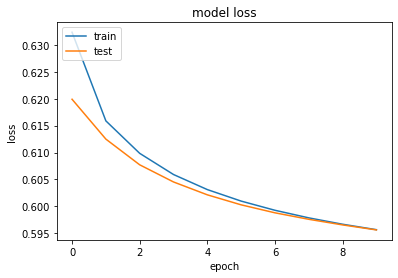

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [25]:
movie_df = pd.read_csv(movielens_dir + "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Mostrando las recomendaciones para el usuario: {}".format(user_id))
print("====" * 9)
print("Peliculas calificadas por el usuario")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 peliculas recomendadas")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Mostrando las recomendaciones para el usuario: 128840
Peliculas calificadas por el usuario
--------------------------------
Fifth Element, The (1997) : Action|Adventure|Comedy|Sci-Fi
Elizabeth (1998) : Drama
Boys Don't Cry (1999) : Drama
Tora! Tora! Tora! (1970) : Action|Drama|War
Man on the Moon (1999) : Comedy|Drama
--------------------------------
Top 10 peliculas recomendadas
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Schindler's List (1993) : Drama|War
Godfather, The (1972) : Crime|Drama
Rear Window (1954) : Mystery|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
12 Angry Men (1957) : Drama
Godfather: Part II, The (1974) : Crime|Drama
Seven Samurai (Shichinin no samurai) (1954) : Action|Adventure|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller


In [29]:
# Guardar el Modelo

model.save_weights("ModeloOctavoPrueba", overwrite=True, save_format=None, options=None)



In [1]:
# Cargar Modelo

model.load_weights("ModeloOctavaPrueba", by_name=False, skip_mismatch=False, options=None)
model.summary()

NameError: name 'model' is not defined

In [43]:
movie_df = pd.read_csv(movielens_dir + "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
user_movie_array
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Mostrando las recomendaciones para el usuario: {}".format(user_id))
print("====" * 9)
print("Peliculas calificadas por el usuario")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 peliculas recomendadas")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Mostrando las recomendaciones para el usuario: 115082
Peliculas calificadas por el usuario
--------------------------------
Aliens (1986) : Action|Adventure|Horror|Sci-Fi
Matrix, The (1999) : Action|Sci-Fi|Thriller
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Star Trek (2009) : Action|Adventure|Sci-Fi|IMAX
Social Network, The (2010) : Drama
--------------------------------
Top 10 peliculas recomendadas
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Godfather, The (1972) : Crime|Drama
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
12 Angry Men (1957) : Drama
Godfather: Part II, The (1974) : Crime|Drama
Spirited Away (Sen to Chihiro no kamikakushi) (2001) : Adventure|Animation|Fantasy
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller
Lives of Others, The (Das leben der Anderen) (2006) : Drama|Romance|Thriller
Planet Earth (2006) : Documentary


## Cargar modelos para calcular las métricas

In [95]:
model.load_weights("ModeloOctavaPrueba", by_name=False, skip_mismatch=False, options=None)
model.summary()

Model: "recommender_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 59047, 50)         8127050   
                                                                 
 embedding_9 (Embedding)     (None, 59047, 1)          162541    
                                                                 
 embedding_10 (Embedding)    (None, 59047, 50)         2952350   
                                                                 
 embedding_11 (Embedding)    (None, 59047, 1)          59047     
                                                                 
Total params: 11,300,988
Trainable params: 11,300,988
Non-trainable params: 0
_________________________________________________________________


In [96]:
ratings = model.predict(x_val)


In [97]:
import random

#ratings = ratings*random.uniform(0.1, 0.9)

ratings

array([[0.602098  ],
       [0.39003325],
       [0.6401219 ],
       ...,
       [0.59695405],
       [0.40849668],
       [0.671179  ]], dtype=float32)

In [98]:

print("MSE {} %".format(mean_squared_error(y_val,ratings)))
print("MAE {} %".format(mean_absolute_error(y_val,ratings)))
print("R2 {} %".format(r2_score(y_val,ratings)))
print("MSLE {} %".format(mean_squared_log_error(y_val,ratings)))


MSE 0.05743478680605734 %
MAE 0.20060987161049842 %
R2 -0.0337640896592295 %
MSLE 0.022301681236335535 %


Text(0, 0.5, 'Density')

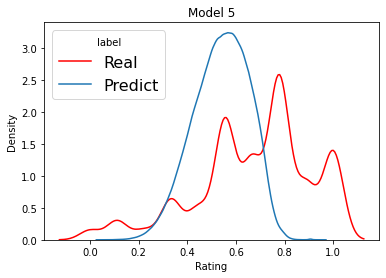

In [100]:

# Draw the density plot
sns.kdeplot(data = y_train, 
                bw_adjust=5,
                label = "Real",
                color = "red")

# Draw the density plot
sns.kdeplot(data = ratings, 
                label = "Predict")

# Plot formatting
plt.legend(prop={'size': 16}, title = 'label')
plt.title('Model 5')
plt.xlabel('Rating')
plt.ylabel('Density')